In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

# Assign the station class to a variable called `Station`
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

'2017-08-23'

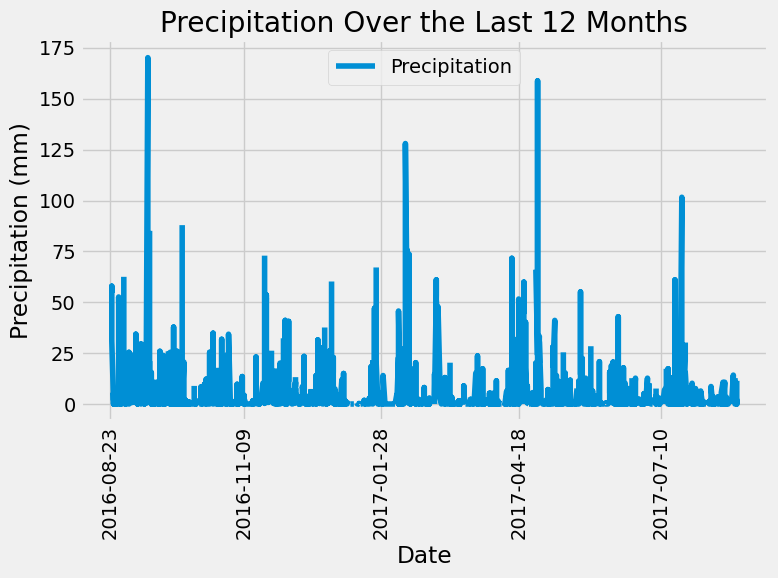

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= latest_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])

# Convert 'Date' to datetime
precip_df['Date'] = pd.to_datetime(precip_df['Date'])

# Sort the dataframe by date
precip_df.set_index('Date', inplace=True)
precip_df.sort_values('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)
ax.plot(precip_df.index, precip_df['Precipitation'], linestyle='-', label='Precipitation')
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")
ax.set_title("Precipitation Over the Last 12 Months")
tick_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
tick_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in tick_dates]
ax.set_xticks(tick_dates)
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in tick_dates], rotation=90)
ax.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [11]:
# Calculate the summary statistics for the filtered precipitation data
summary_stats = precip_df.describe()
summary_stats

,Precipitation
count,2015.000000
mean,4.485112
std,11.690532
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")

temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most active station: USC00519281
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


Most active station: USC00519281


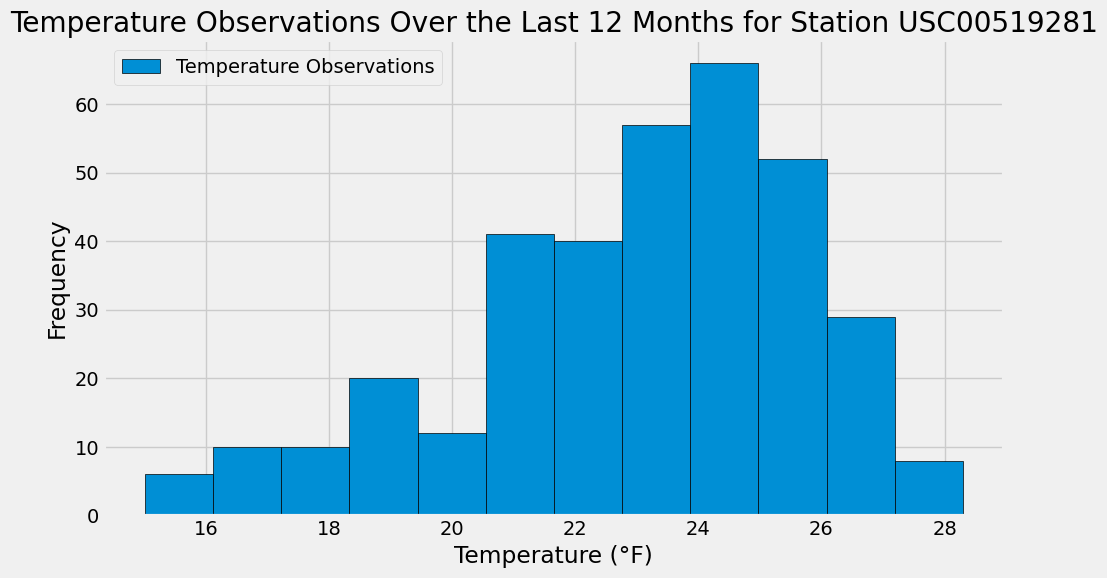

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = active_stations[0][0]
print(f"Most active station: {most_active_station}")

one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

temp_df = pd.DataFrame(temp_data, columns=['Date', 'Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, edgecolor='black', label='Temperature Observations')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations Over the Last 12 Months for Station ' + most_active_station)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close

<bound method Session.close of <sqlalchemy.orm.session.Session object at 0x0000019CE16C6140>>